In [1]:
# Import all libraries

import pandas as pd
import numpy as np
import glob
import os
import pickle
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
# disable warnings from pickled models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

In [4]:
def get_data(path):
    parquet_files = glob.glob(os.path.join(path, "*.parquet"))
    data = pd.concat((pd.read_parquet(f) for f in parquet_files))

    inputs = data[['sqfeet',
                'beds',
                'baths',
                'income',
                'density']]
                
    outputs = data['price']
    x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size = 0.2, random_state=2)
    return x_train, x_test, y_train, y_test

In [5]:
def evaluate_models(data_path, model_path):
    x_train, x_test, y_train, y_test = get_data(data_path)
    models = glob.glob(os.path.join(model_path, "*.pkl"))
    nn_models = glob.glob(os.path.join(model_path, "*.h5"))
    poly, scaler = None, None
    temp_models = []
    # filter out polynomial features and scaler
    for name in models:
        val = name.replace(model_path+'/', '').split('.')[0]
        if 'scaler' in val:
            scaler = pickle.load(open(name, 'rb'))
        elif 'poly' in val:
            poly = pickle.load(open(name, 'rb'))
        else:
            temp_models.append(name)
    
    models = temp_models
    #initialize scaler and polynomial features
    if scaler is not None:
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
        if poly is not None:
            x_train = poly.transform(x_train)
            x_test = poly.transform(x_test)
    display(poly)
    display(scaler)
    outputs = []
    models.sort()
    for name in models:
        model = pickle.load(open(name, 'rb'))
        t_score = model.score(x_train, y_train)
        score = model.score(x_test, y_test)
        outputs.append([name.replace(model_path+'/', '').split('.')[0], t_score, score])
    for name in nn_models:
        model = load_model(name)
        y_pred = model.predict(x_train)
        t_score = r2_score(y_train, y_pred)
        # floor r^2 to 0
        if t_score < 0:
            t_score = 0
        y_pred = model.predict(x_test)
        score = r2_score(y_test, y_pred)
        # floor r^2 to 0
        if score < 0:
            score = 0
        outputs.append([name.replace(model_path+'/', '').split('.')[0], t_score, score])
    return pd.DataFrame(outputs, columns=['Model', 'Train R2 Score', 'Test R2 Score'])

In [6]:
def graph_results(results, title):
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.bar(results['Model'], results['Train R2 Score'], width=0.8, color='red', label='Training Data $R^2$ Score')
    ax.bar(results['Model'], results['Test R2 Score'], width=0.8, color='blue', label='Test Data $R^2$ Score')
    ax.set_xlabel("Model", fontsize=20)
    ax.set_ylabel("$R^2$ Score", fontsize=20)
    plt.title(title, fontsize=30)
    plt.xticks(rotation = 30, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    ax.legend(fontsize=20, loc='lower right')
    plt.show()


In [7]:
def plot_results(pred, act):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(act, act, color='r')
    ax.scatter(act, pred, color='b')
    ax.set_xlabel('Real')
    ax.set_ylabel('Generated')
    plt.tight_layout()
    plt.show()

In [8]:
rental_res = evaluate_models('../data_engineering/outputs/rental/','./outputs/rent_models')
display(rental_res)

None

None

2022-12-08 18:49:52.860179: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Model,Train R2 Score,Test R2 Score
0,catboost,0.652876,0.640454
1,catboost_gridsearch,0.630195,0.621613
2,decision_tree,0.990470,0.716006
3,decision_tree_gridsearch,0.990375,0.714441
4,knn,0.863810,0.787744
5,knn_gridsearch,0.903282,0.792934
6,lassomodel,0.372165,0.368331
7,linmodel,0.372208,0.368333
8,randforest_search,0.969436,0.830942
9,random_forest,0.968863,0.829661


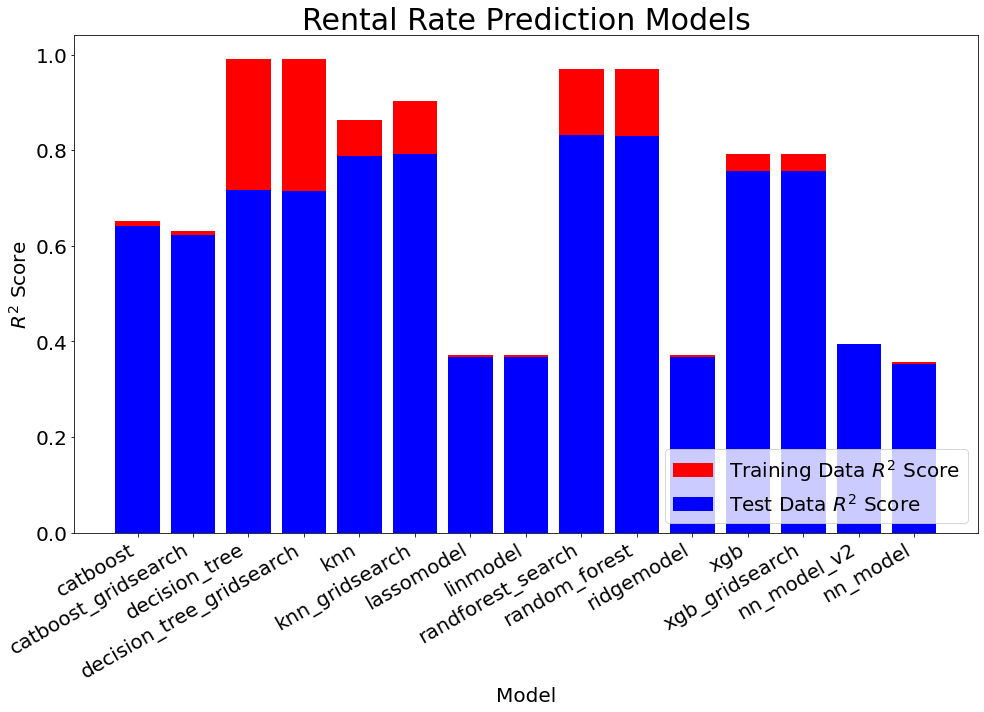

In [9]:
graph_results(rental_res, "Rental Rate Prediction Models")

In [10]:
sale_res = evaluate_models('../data_engineering/outputs/sales/','./outputs/sale_models')
display(sale_res)

None

None

,Model,Train R2 Score,Test R2 Score
0,catboost,0.919642,0.916287
1,catboost_gridsearch,0.906517,0.902600
2,decision_tree,0.998386,0.972628
3,decision_tree_gridsearch,0.998383,0.979601
4,knn,0.976476,0.963503
5,knn_gridsearch,0.997088,0.984940
6,lassomodel,0.388202,0.378506
7,linmodel,0.388202,0.378506
8,randforest_search,0.995970,0.985735
9,random_forest,0.995996,0.985878


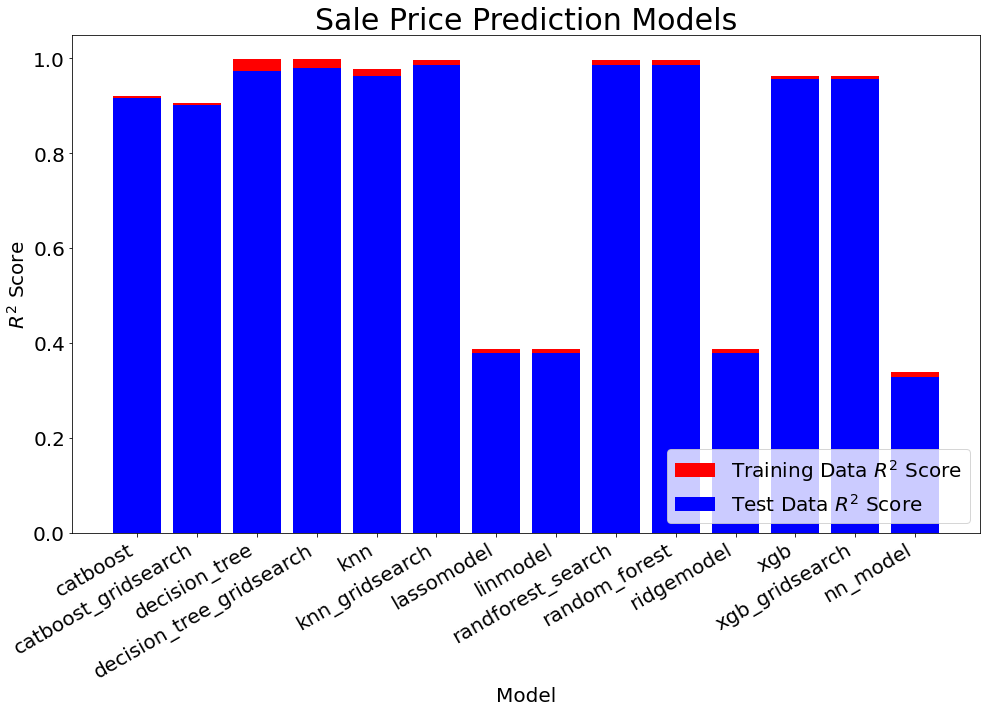

In [11]:
graph_results(sale_res, "Sale Price Prediction Models")

In [12]:
rental_res2 = evaluate_models('../data_engineering/outputs/rental/','./outputs/rent_models_scaled')
display(rental_res2)

None

MinMaxScaler()

,Model,Train R2 Score,Test R2 Score
0,lassomodel_2,0.362334,0.360056
1,linmodel_2,0.372208,0.368333
2,ridgemodel_2,0.372205,0.368364
3,nn_model_2,0.000000,0.000000


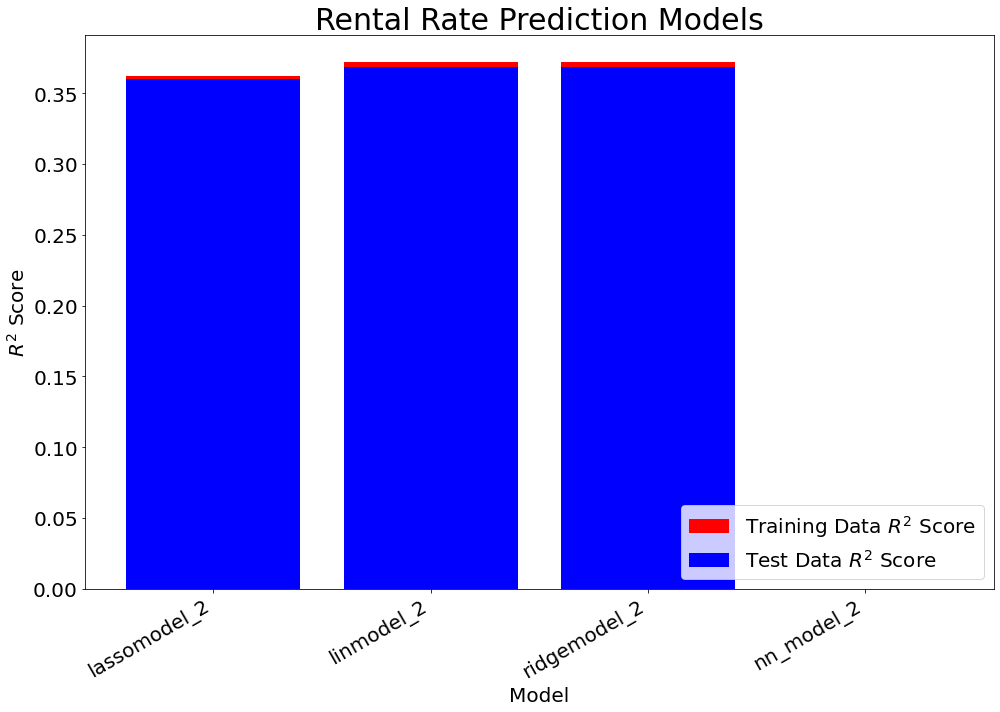

In [13]:
graph_results(rental_res2, "Rental Rate Prediction Models")

In [14]:
rental_res3 = evaluate_models('../data_engineering/outputs/rental/','./outputs/rent_models_scaled_poly')
display(rental_res3)

PolynomialFeatures()

MinMaxScaler()

,Model,Train R2 Score,Test R2 Score
0,lassomodel_2,0.362334,0.360056
1,linmodel_2,0.403914,0.403520
2,ridgemodel_2,0.402954,0.402218
3,nn_model_2,0.000000,0.000000


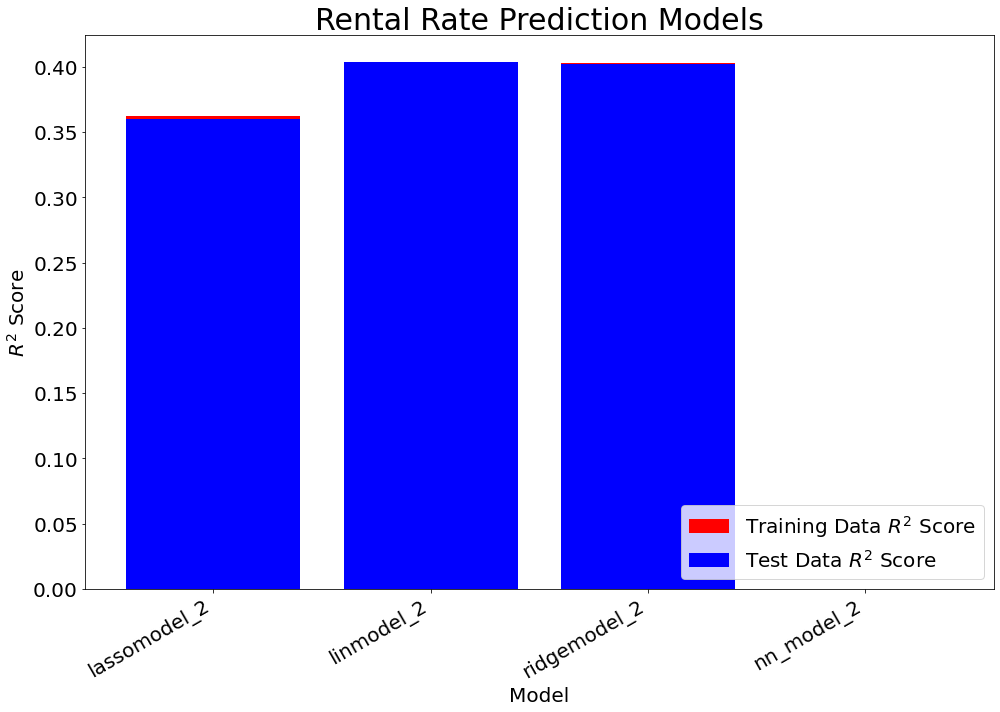

In [15]:
graph_results(rental_res3, "Rental Rate Prediction Models")

In [16]:
sale_res2 = evaluate_models('../data_engineering/outputs/sales/','./outputs/sale_models_scaled')
display(sale_res2)

None

MinMaxScaler()

,Model,Train R2 Score,Test R2 Score
0,lassomodel_2,0.388202,0.378506
1,linmodel_2,0.388202,0.378506
2,ridgemodel_2,0.388202,0.378505
3,nn_model_2,0.000000,0.000000


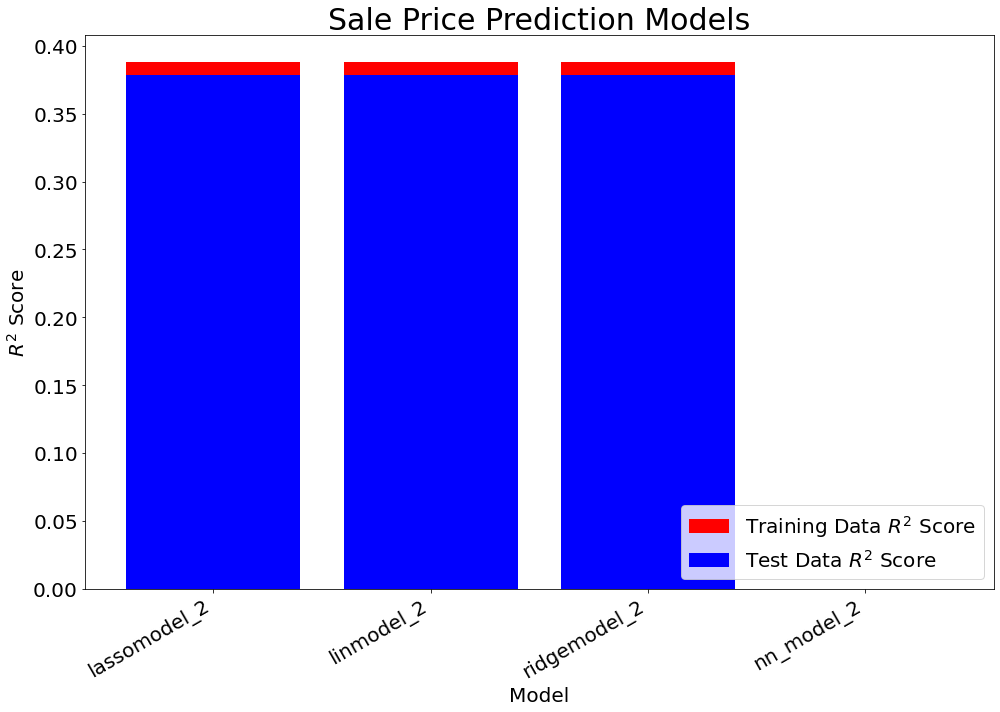

In [17]:
graph_results(sale_res2, "Sale Price Prediction Models")

In [18]:
sale_res3 = evaluate_models('../data_engineering/outputs/sales/','./outputs/sale_models_scaled_poly')
display(sale_res3)

PolynomialFeatures()

MinMaxScaler()

,Model,Train R2 Score,Test R2 Score
0,lassomodel_2,0.640299,0.640629
1,linmodel_2,0.640299,0.640632
2,ridgemodel_2,0.640292,0.640566
3,nn_model_2,0.000000,0.000000


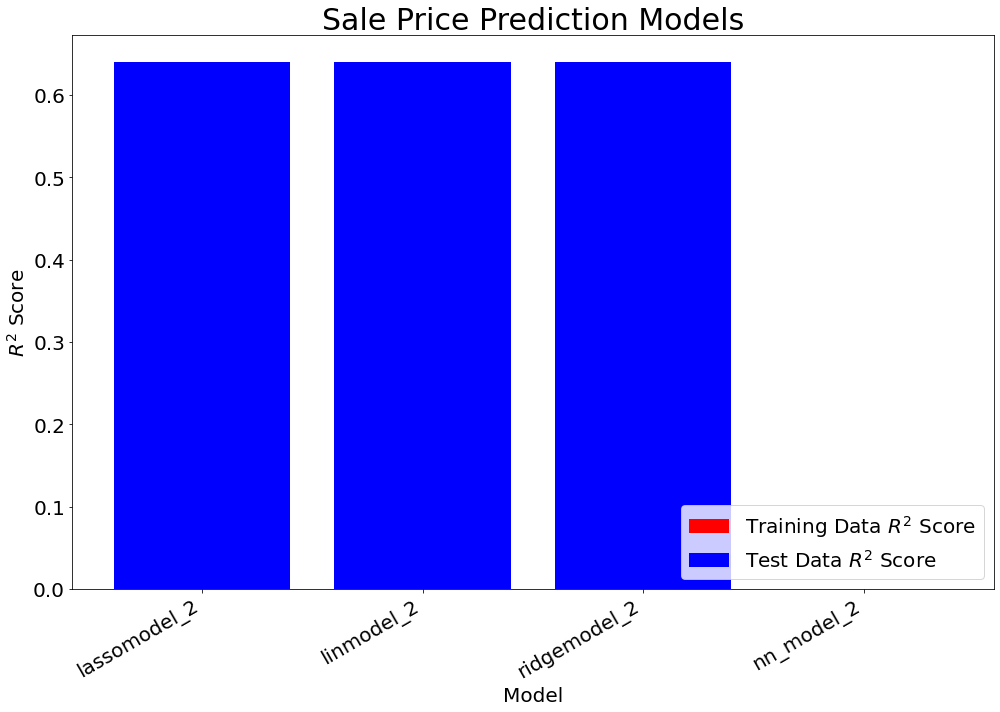

In [19]:
graph_results(sale_res3, "Sale Price Prediction Models")